<center>

# Logic, Learning, and Decision

## Home Assignment 2

### Model Checking with $\mu%$-Calculus & Controlling through Q-Learning
</center>

- - -

# Introduction

The first objective of this home assignment is to deepen the understanding of temporal logic specifications and model checking algorithms based on $\mu$-calculus. You will achieve that through implementing a fixed-point algorithm for a particular _CTL*_ specification and test it out on a booking problem of variable size. 

The second objective is to obtain a basic understanding of a central Reinforcement Learning algorithm called *Q-learning*.

This home assignment is performed in *two member groups*. Write all your answers into this notebook and **submit only this notebook (.ipynb) containing your team's own original work on Canvas.**

## Comments and Recommendations
As always:
* The following resources will be of great help to you for this assignment:
  * Lecture Notes
  * [Python docs](https://docs.python.org/3/)
  * [Google](https://www.google.com)
* This assignment is written for Python 3.5 or later!
* We will test your code with additional edge cases. So convince yourself that everything is correct before you submit.
* This assignment makes use of the Python packages [numpy](https://docs.scipy.org/doc/numpy/) and [matplotlib](https://matplotlib.org/index.html). Make sure to have it installed.

In [1]:
try:
    import numpy as np
except ImportError:
    print("You need to install numpy! Open a command prompt and run 'pip install numpy'")

try:
    import matplotlib.pyplot as plt
except ImportError:
    print("You need to install matplotlib! Open a command prompt and run 'pip install matplotlib'")

import platform
if platform.system() == 'Windows':
    try:
        import msvc_runtime
    except ImportError:
        print("You may need to install msvc-runtime for multiprocessing! " + 
        "If you have issues with the function `eval_hyperparam_grid`, open " + 
        "a command prompt and run 'pip install msvc-runtime'. Then restart the kernel.")

---

# Part 1: Model Checking with $\mu-$Calculus

Imagine you are employed by a company, but you are quite unhappy recently, because the system you are working with (for instance, a manufacturing cell, but could be anything else) exhibits some strange behavior and just freezes randomly. So, you decide to model the system (i.e. manufacturing cell, etc) and analyze it with the methods from your favorite course at university. Hence, you come up with the petri net $P_1$:
![petri net](fig/petri_net.png)
Two parallel processes require two resources $R_1$ and $R_2$ for their operations. This is a classic booking problem. Although appearing simple, this system may exhibit undesirable behavior. For the majority of Part 1 of the assignment we will work with this system. 

In [2]:
from util import PetriNet
from util import Place, Arc
from util import plot_petrinet


def make_petrinet(p11_tokens, p21_tokens, R1_tokens, R2_tokens):
    return PetriNet(places=[Place('p11', p11_tokens), Place('p12', 0),
                            Place('p21', p21_tokens), Place('p22', 0),
                            Place('R1', R1_tokens), Place('R2', R2_tokens)],
                    transitions={'a1', 'b1', 'a2', 'b2'},
                    arcs={Arc('p11', 'a1', 1),
                          Arc('a1', 'p12', 1),
                          Arc('p12', 'b1', 1),
                          Arc('b1', 'p11', 1),
                          Arc('R1', 'a1', 1),
                          Arc('R1', 'b2', 1),
                          Arc('b1', 'R1', 1),
                          Arc('b2', 'R1', 1),
                          Arc('R2', 'a2', 1),
                          Arc('R2', 'b1', 1),
                          Arc('b1', 'R2', 1),
                          Arc('b2', 'R2', 1),
                          Arc('p21', 'a2', 1),
                          Arc('a2', 'p22', 1),
                          Arc('p22', 'b2', 1),
                          Arc('b2', 'p21', 1)})


P_1 = make_petrinet(p11_tokens=3, p21_tokens=2, R1_tokens=2, R2_tokens=1)

We have also implemented a function for you in the PetriNet class that generates the corresponding reachability graph.

P_1:


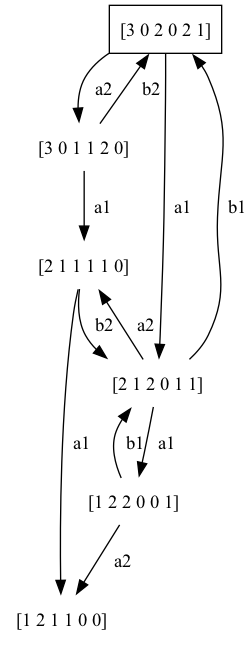

In [3]:
from util import plot_digraph

print('P_1:')
plot_digraph(P_1.make_reachability_graph(), 'fig/P_1_reach_graph')

To be able to use $\mu$-calculus to check the Petri net model, we need to transform it into a transition system, though. 

---

## Transition Systems

In this assignment, we will work with a more general model for discrete event systems called __Transition System__. A transition system $G$ is defined by a 6-tuple $G = \langle X, \Sigma, T, I, AP, \lambda \rangle$ where $X$ is a set of states, $\Sigma$ is a finite set of events, $T \subseteq X \times T \times X$ is a transition relation, where a transition $t = (x, a, x') \in T$, includes the source state $x$, the event label $a$, and the target state $x'$, $I \subseteq X$ is a set of possible initial states, $AP$ is a set of atomic propositions, and $\lambda: X \mapsto 2^{AP}$ is a state labeling function. A transition system  $G$ without the state labels, where $AP$ and $\lambda$ are excluded from $G$ is obviously an automaton without marked and forbidden states.

In order to implement a data structure corresponding to a transition system, we introduce a new class of _State_ objects.

In [4]:
class State(object):
    
    def __init__(self, name, labels=None):
        """
        Constructor  of the state.
        
        :param name: String. Default atomic proposition of the state
        :param labels: Set of atomic propositions that a true in the state
        """
        self.name = name
        assert labels is None or type(labels) is set
        self.labels = {name} if not labels else labels | {name}
    
    def __str__(self):
        """Prints the state in a pretty way."""
        return 'name: {} & ' \
               'labels: {}'.format(self.name, self.labels)
        
    def is_satisfied(self, atomic_proposition):
        """Checks whether the atomic proposition is statisfied in the state."""
        return atomic_proposition in self.labels

That allows us to define the _TransitionSystem_ class:

In [5]:
from util import Transition


class TransitionSystem(object):

    def __init__(self, states, init, events, trans):
        """
        This is the constructor of the transition system.

        At creation, the automaton gets the following attributes assigned:
        :param states: A set of States
        :param init: A set of initial States
        :param events: A set of events
        :param trans: A set of transitions
        """
        assert isinstance(states, set)
        self.states = states
        assert isinstance(init, set)
        self.init = init
        assert isinstance(events, set)
        self.events = events
        assert isinstance(trans, set)
        self.trans = trans

    def __str__(self):
        """Prints the transition system in a pretty way."""
        states_str = '{\n\t' + ',\n\t'.join(
            [str(s) for s in self.states]) + '\n\t}'
        init_str = '{\n\t' + ', '.join([str(s.name) for s in self.init]) + '\n\t}'
        trans_str = '\n\t'.join(
            ['{} --{}--> {},'.format(t.source.name, t.event, t.target.name) for t in self.trans])
        trans_str = '{\n\t' + trans_str + '\n\t}'
        return 'states: \n\t{}\n' \
               'init: \n\t{}\n' \
               'events: \n\t{}\n' \
               'transitions: \n\t{}\n'.format(
                   states_str, init_str, self.events, trans_str)

    def __eq__(self, other):
        """Checks if two transition systems are the same"""
        if type(other) is type(self):
            return self.__dict__ == other.__dict__
        return False

Now, we can translate our Petri net $P_1$ of the booking problem that we are working with into a *TransitionSystem* via its reachability graph.

T_1:


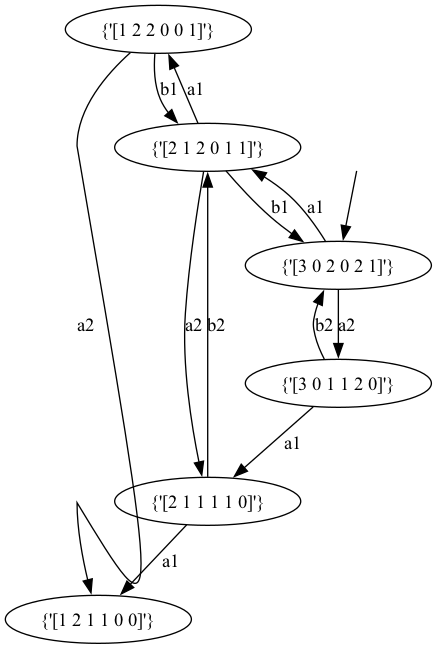

In [6]:
from util import plot_transitionsystem


def make_transition_system(petri_net):
    """Transforms a PetriNet to a TransitionSystem."""
    G = petri_net.make_reachability_graph()
    states = {State(n) for n in G.nodes}
    
    def get_state(node):
        for s in states:
            if s.name == node:
                return s
    
    init = {get_state(G.init)}
    events = petri_net.transitions
    trans = {Transition(get_state(e.source), e.label, get_state(e.target)) for e in G.edges}
    return TransitionSystem(states, init, events, trans)


T_1 = make_transition_system(P_1)
print('T_1:')
plot_transitionsystem(T_1, 'fig/P_1_transition_system')

---

## Task 1.1 

### ___CTL*___-Specification to $\mu$-Calculus *[2p]*

In this assignment, you will implement the $\mu$-calculus algorithms for the booking problem $P_i$ shown above. Specifically, you will check its TransitionSystem model $T_i$ for the following temporal logic specification given in ___CTL*___:

<center>
    $\varphi_i = \forall \square \exists \lozenge m_i$,
</center>
with $m_i$ indicating a specific initial marking of $P_i$ (e.g. $m_1 = [3 0 2 0 2 1]$). 

* In simple words, what does this specification $\varphi_1 = \forall \square \exists \lozenge m_1$ say and why does it specify a desired behavior? Write your answer below. ***[1p]***

It means that you will/can forever, always, take a path which eventually leads you to a marking. Means that no matter how many times or what path you take you can always reach a desired state m_i. There are no blocking states.


Now, 
* transform the ___CTL*___ formula $\varphi_1$ to $\mu$-calculus set expressions. Show also intermediate results. ***[1p]***
* *Note*: [This webpage](http://detexify.kirelabs.org/classify.html) may be useful for finding the right LaTex symbols.
* *Hint:* The double square brackets $[\![p]\!]$ can be done with [ \ ! [ p ] \ ! ] within the math environment. The LaTeX environments of the [amsmath package](https://tex.stackexchange.com/questions/3782/how-can-i-split-an-equation-over-two-or-more-lines) are also supported (equation, multiline and split).

---

## Task 1.2 
### $\text{Pre}^\exists$ Operator *[1p]*

$\mu$-calculus includes next modality functions $f \in \mathcal{F}$, namely $f = \exists \bigcirc$ and $f = \forall \bigcirc$. You will implement $f = \exists \bigcirc$ as __predecessor set operation__ in this section of the assignment. We will need this operator to check our model of the booking problem. 

This set operator is defined as

<center>
   $\text{Pre}^\exists(Y) = \{x \mid (\exists a \in \Sigma(x))\delta(x, a) \subseteq Y \}$, 
</center>
where $x \in X$ and $Y \in 2^X$.

Now,
* implement the $\text{Pre}^\exists$ set operator in the `pre_exists` function.
* _Hint:_ The inbuilt Python function [`any`](https://docs.python.org/3/library/functions.html#any) might be useful here.

In [7]:
# You might want to use one of these...
from util import filter_trans_by_source, filter_trans_by_events, filter_trans_by_target
from util import extract_elems_from_trans, flip_trans

In [8]:
def pre_exists(Y, ts):
    """
    Returns the new set of states for which the exists next modality is true.
    
    :param Y: Set of States
    :param ts: TransitionSystem
    """
    # YOUR CODE HERE
    raise NotImplementedError()
    return Y

In [9]:
# space for your own tests

In [10]:
# s1 = State(1)
# s2 = State(2)

# T0 = TransitionSystem({s1}, {s1}, set(), set())
# assert pre_exists(set(), T0) == set()
# assert pre_exists({s1}, T0) == set()

# T1 = TransitionSystem({s1}, {s1}, {'a'}, {Transition(s1, 'a', s1)})
# assert pre_exists(set(), T1) == set()
# assert pre_exists({s1}, T1) == {s1}

# T2 = TransitionSystem({s1, s2}, {s1}, {'a'}, {Transition(s1, 'a', s2)})
# assert pre_exists(set(), T2) == set()
# assert pre_exists({s1}, T2) == set()
# assert pre_exists({s2}, T2) == {s1}
# assert pre_exists({s1, s2}, T2) == {s1}

This $\text{Pre}^\forall$ set operator for $f = \forall \bigcirc$ is defined as

<center>
   $\text{Pre}^\forall(Y) = \{x \mid (\forall a \in \Sigma(x))\delta(x, a) \subseteq Y \}$, 
</center>
where $x \in X$ and $Y \in 2^X$.

An implementation is given below.

In [11]:
def pre_forall(Y, ts):
    """
    Returns the new set of states for which the forall next modality is true.
    
    :param Y: Set of States
    :param ts: TransitionSystem
    """
    def all_t_into_Y_from(source):
        out_transitions = filter_trans_by_source(ts.trans, {source})
        return all({t.target in Y for t in out_transitions})
    
    Y = {x for x in ts.states if all_t_into_Y_from(x)}
    return Y

---

## Task 1.3

### Model Checking through Fixed-Point Iteration *[2p]*

After having reformulated $\varphi_i = \forall \square \exists \lozenge m_i$ as $\mu$-calculus set expressions, and having obtained an implementation of both $\text{Pre}^\exists$ and $\text{Pre}^\forall$, we can start on the actual model checking algorithm. 

* Implement the function `is_always_eventually_satisfied` that takes as inputs an atomic proposition (e.g. $m_i$) and a TransitionSystem. It then checks whether the TransitionSystem satisfies $\varphi_i$. ***[2p]***
* _Hint:_ You need to implement both a least fixed-point iteration $\mu Z$ and a greatest fixed-point iteration $\nu Y$.

In [12]:
# def is_always_eventually_satisfied(m_i, ts):
#     """
#     Checks if a TransitionSystem always eventually satisfies an atomic proposition.
    
#     :param m_i: String/integer. Atomic proposition
#     :param ts: TransitionSystem to check
#     """
#     satisfied = False
#     # YOUR CODE HERE
#     raise NotImplementedError()
#     return satisfied


# m_1 = '[3 0 2 0 2 1]'
# print('T_1 {} satisfy phi_1!'.format('does' if is_always_eventually_satisfied(m_1, T_1) else 'does NOT'))

In [13]:
# space for your own tests

In [14]:
# s1 = State(1, {'AP'})
# s2 = State(2)

# T0 = TransitionSystem({s1}, {s1}, set(), set())
# assert is_always_eventually_satisfied(1, T0) == True
# assert is_always_eventually_satisfied('AP', T0) == True

# T1 = TransitionSystem({s1}, {s1}, {'a'}, {Transition(s1, 'a', s1)})
# assert is_always_eventually_satisfied(1, T1) == True

# T2 = TransitionSystem({s1, s2}, {s1}, {'a'}, {Transition(s1, 'a', s2)})
# assert is_always_eventually_satisfied(1, T2) == False
# assert is_always_eventually_satisfied(2, T2) == True

# T3 = TransitionSystem({s1, s2}, {s1}, {'a'}, {Transition(s1, 'a', s1), Transition(s1, 'a', s2)})
# assert is_always_eventually_satisfied(1, T3) == False
# assert is_always_eventually_satisfied(2, T3) == True

# T4 = TransitionSystem({s1, s2}, {s1}, {'a'}, {Transition(s1, 'a', s1), 
#                                               Transition(s1, 'a', s2), 
#                                               Transition(s2, 'a', s2)})
# assert is_always_eventually_satisfied(1, T4) == False
# assert is_always_eventually_satisfied(2, T4) == True

# s3 = State(3)
# s4 = State(4, {3})
# T5 = TransitionSystem({s1, s2, s3, s4}, {s1, s2}, {'a', 'b'}, 
#                       {Transition(s1, 'a', s3),
#                        Transition(s1, 'b', s4),
#                        Transition(s2, 'a', s4)})
# assert is_always_eventually_satisfied("AP", T5) == False
# assert is_always_eventually_satisfied(2, T5) == False
# assert is_always_eventually_satisfied(3, T5) == True
# assert is_always_eventually_satisfied(4, T5) == False

# T6 = TransitionSystem({s1, s2, s3, s4}, {s1}, {'a', 'b'}, 
#                       {Transition(s1, 'a', s2),
#                        Transition(s1, 'b', s3),
#                        Transition(s2, 'a', s1),
#                        Transition(s2, 'b', s4),
#                        Transition(s3, 'a', s1),
#                        Transition(s3, 'b', s4),
#                        Transition(s4, 'a', s2)})
# assert is_always_eventually_satisfied(1, T6) == True
# assert is_always_eventually_satisfied(2, T6) == True
# assert is_always_eventually_satisfied(3, T6) == True
# assert is_always_eventually_satisfied(4, T6) == True

---

## Task 1.4

### Solving the Booking Problem *[1p]*

It seems that there is an issue with the booking of the resources in the system (the Petri net from earlier) at some point. And that even pertains when we scale the system.

In [15]:
# # e.g. multiplying all tokens by factor 7
# m_2 = '[21 0 14 0 14 7]'
# T_2 = make_transition_system(make_petrinet(p11_tokens=21, p21_tokens=14, R1_tokens=14, R2_tokens=7))
# print('T_2 {} satisfy phi_2!'.format('does' if is_always_eventually_satisfied(m_2, T_2) else 'does NOT'))

# """
# !!! PLEASE COMMENT OUT THE LINE BELOW BEFORE SUBMISSION !!!
# """
# # plot_transitionsystem(T_2, 'fig/T_2')

Given that observation:

* Change $P_1$ so that the booking problem is resolved. Elements of the original structure of the Petri net (places and arcs) must not be removed in that. ***[1p]***
* *Hint:* Based on the model you could figure out what the problem is, and start to experiment with the model to find a way to prevent the problem from occurring. 

In [16]:
# from util import array_str


# def make_fixed_petrinet():
#     """Makes a new, altered, issue-free version of P_1"""
#     # YOUR CODE HERE
#     raise NotImplementedError()
#     return P


# P_3 = make_fixed_petrinet()
# T_3 = make_transition_system(P_3)
# print('T_3 {} satisfy phi_3!'.format('does' if is_always_eventually_satisfied(array_str(P_3.init_marking), T_3)
#                                      else 'does NOT'))
# print('P_3:')
# plot_petrinet(P_3, 'fig/P_3')

Finally, you found a configuration of your model for which everything is fine. You get super excited and burst into your boss' office, and exclaim: _"I know how to fix our problem with the system! Give me a raise!"_ And your boss gets super excited and asks you how to solves her greatest nightmare. Obviously, you cannot say now: _"We need to get a big can of paint and draw some circles and arrows on the floor!"_ (except maybe if you know some ancient magic ritual against booking problems). No, you need to translate your model changes into your boss' world, i.e. do we need to change the process, buy new equipment, re-program the controllers, etc. Also, you cannot decide that one of the resources is no longer needed for processing or remove one of the two processes altogether. In other words, the places, transitions and arcs of the original petri net $P_1$ must remain. You can add places and so on, or adjust the number of tokens as long  as the original structure is part of the new model and you can motivate your changes in words that are understandable to your manager, who knows nothing about discrete event systems.

* Describe briefly in words how you could implement your proposed changes in the real system. ***[1p]***

YOUR ANSWER HERE

## Bonus Task (optional)

* Can you derive a general rule to avoid the booking problem for the given Petri net structure of $P_1$, that is a booking problem with two parallel processes? If yes, explain it with a few words. ***[+1p]***

YOUR ANSWER HERE

---

# Part 2: Reinforcement Learning

After having had a tremendously successful day at work, you call your friends to share the story of how you single-handedly solved your company's booking issue using $\mu$-calculus. All agree that this needs to be celebrated accordingly, and so you meet up at Andra Långgatan. Your likely future promotion is cause for a long and jolly evening, and when you finally decide to go home, it has become quite dark already. To make matters even worse, a strong wind is blowing from south/south-west, and you seem to have forgotten the way to your home in Gamlestaden (for whatever reason - blame it on the long day thinking about temporal logic if you'd like). You conclude that your best option would be to start walking in some direction in the hope of finding your home eventually. But careful! If you walk too close alongside the Göta Älv, the strong wind might blow you into the river. In addition to the unpleasant experience, the river will take you back to Järntorget and you need to start your journey home all over again. And if that wasn't bad enough yet, you might get convinced to join some _"late-night studying"_ if you pass by J. A. Pripps at Chalmers.   

In this part of the assignment, you will implement a Reinforcement Learning algorithm called Q-learning. Reinforcement Learning uses data sampled from the plant (or the environment in RL terms) to derive an optimal controller - just right for finding your way back home.

Let us look at the environment first:

![WindyGothenburg](fig/windy_gothenburg.png)

The available actions in this environment are: {'north', 'east', 'south', 'west'}. In addition to the action you take, the wind will blow you with a probability of 5% to the east and with a probability of 10% to the north. To start with, we simplify the environment by removing the river and J.A. Pripps. These two features will be added again later on. You can find the full code of the environment in `util/datastructures.py`. Here, we will import it and configure it now:

In [17]:
from util import WindyGothenburg

BASIC_ENV = {'name': 'Basic Env', 
             'w': 12, 'h': 12,                    # width and height of the grid
             'obstacles': {(2,9), (3,9), (4,9),
                          (8,9), (9,9), (10,9)},  # Coordinates of obstacles on the grid 
             'water': set(),                      # Coordinates of the Göta Älv (not included in this env)
             'pripps_reward': None}               # Reward for passing by J.A. Pripps (not included in this env)

The RL algorithm that you will implement is as follows:

**Algorithm 1.** Q-learning$(\alpha, \epsilon, \gamma)$

>Initialize $Q(x,a)$ arbitrarily
>
>**for all** episodes **do**
>
>>Initialize $x$
>>
>>**for all** steps of episode  **do**
>>>
>>>Choose $a$ in $x$ using policy derived from $Q$ (e.g. $\epsilon$-greedy)
>>>
>>>Take action $u$, observe $r$, $x'$
>>>
>>>$Q(x,a) = Q(x,a) + \alpha \left[r + \gamma \max_{a'} Q(x', a') - Q(x,a) \right]$
>>>
>>>$x = x'$
>>>
>>**end for**
>
>**end for**
>
**return** $\pi(a) = argmax_a Q(x, a)$

We have already implemented parts of this algorithm for you. Make sure to read carefully all the functions below. One of those functions creates the Q-table by using nested Python [dictionaries](https://docs.python.org/3/library/stdtypes.html#mapping-types-dict). 

In [18]:
import random

def initialize_Q(states, actions, scaling_factor=0.1):
    """
    Initializes the Q-table as a dictionary of dictionaries.
    
    A particular Q-value can be retrieved by calling Q[x][a].
    All actions and their associated values in a state x can 
    be retrieved through Q[x].
    Q-values are initialized to a small random value to encourage 
    exploration and to facilitate learning.
    
    :param states: iterable set of states
    :param actions: iterable set of actions
    """
    return {x: {a: random.random() * scaling_factor for a in actions} for x in states}

def argmax_Q(Q, state):
    """Computes the argmax of Q in a particular state."""
    max_q = float("-inf")
    argmax_q = []
    for a, q in Q[state].items():
        if q == max_q:
            argmax_q.append(a)
        if q > max_q:
            max_q = q
            argmax_q = [a]
    return random.choice(argmax_q)

---

## Task 2.1

### Finding Home through Q-learning *[1p]*

As a first task, implement a function that chooses with probability $1-\epsilon$ the action with the highest $Q$-value in a given state (i.e. it chooses greedily), and with probability $\epsilon$ a random action, where $0 < \epsilon < 1$. This is a popular exploration strategy in RL that ensures that all states are visited theoretically infinitively often.

* Implement the $\epsilon$-greedy choice in code. 
* *Hint*: You might want to use the Python function [random.random()](https://docs.python.org/3/library/random.html#random.random) and [random.choice()](https://docs.python.org/3/library/random.html#random.choice).
* *Hint*: You might want to read the documentation of [dictionaries](https://docs.python.org/3/library/stdtypes.html#mapping-types-dict) again.

In [19]:
def choose_epsilon_greedily(Q, x, epsilon):
    """
    Chooses random action with probability epsilon, else argmax_a(Q(*|x))
    
    :param Q: Q-table as dict of dicts
    :param x: state
    :param epsilon: float
    """
    # YOUR CODE HERE
    rng = random.random()
    
    if rng > epsilon:
        #choose greedyly
        action = argmax_Q(Q,x)
    else:
        #choose non greedy\
        action = random.choice(list(Q[x]))
    return action

Next, we need to implement a function that decides how fast our RL algorithm will be learning. Generally, the learning rate $\alpha_k$ must satisfy the conditions $\sum_{k=0}^\infty \alpha_k^2 < \infty$ and $\sum_{k=0}^\infty \alpha_k = \infty$, to be able to guarantee that the estimates of Q converge to the optimal Q-function.

* Implement a function that computes $\alpha$ given the state-action visitation count $k$. 
* *Hint*: Check the lecture notes for further information.

A correct implementation of both functions is needed to complete Task 2.1. 

In [20]:
def get_alpha(x, a, stateaction_visitation_counts, A, B):
    """
    Returns a value of the learning rate.
    
    A particular state-action visitation count can be 
    retrieved by calling stateaction_visitation_count[x][a].
    :param x: state
    :param a: action
    :param stateaction_visitation_counts: dictionary of dictonaries
    :param A: integer parameter of the learning rate
    :param B: integer parameter of the learning rate
    """
    # YOUR CODE HEre 
    # antar B = 2A
    N=stateaction_visitation_counts[x][a]
    alpha = A / (N + B) # formel från s.5 i  LLD Lecture Notes Reinforcement Learning.pdf
    return alpha

In [21]:
# epsilon-greedy tests
Q1 = initialize_Q(states={1}, actions={'a'})
assert choose_epsilon_greedily(Q1, 1, 0.1) == 'a'

Q2 = initialize_Q(states={1}, actions={'a', 'b'})
Q2[1]['a'] = 1
Q2[1]['b'] = 0
assert choose_epsilon_greedily(Q2, 1, 0.0) == 'a'

epsilon = 0.1
k = 0
l = 0
for m in range(1000):
    action = choose_epsilon_greedily(Q2, 1, epsilon)
    k = k + 1 if action == 'a' else k
    l = l + 1 if action == 'b' else l
assert k/m >= (1-epsilon)
assert l/m > 0.0

# learning rate tests
x = (0, 0)
svc = {x: {'a': 0}}
assert 0.0 < get_alpha(x, 'a', svc, 1, 2) < 1.0
assert 0.0 < get_alpha(x, 'a', svc, 1e10, 2e10) < 1.0
svc = {x: {'a': 1e10}}
assert 0.0 < get_alpha(x, 'a', svc, 1, 2) < 1.0
assert 0.0 < get_alpha(x, 'a', svc, 1e10, 2e10) < 1.0

Finally, we can turn to the $Q$-learning algorithm. We have made a start with it already. 

* Now, implement the $Q$-value update from Algorithm 1. The relevant line is marked with a comment in the code below. 

In [22]:
def learn_q(env, epsilon, gamma, A, B, num_episodes=250, max_steps=100, render=False, test=False):
    
    Q = initialize_Q(env.states, env.actions, scaling_factor=0.1)
    counts =  {x: {a: 0 for a in env.actions} for x in env.states}
    
    stats = {'avg_r_smoothed': 0, 'eps_goal_found': num_episodes, 
             'eps_goal_learned': num_episodes, 'max_r_smoothed': 0}
    
    if A>B:
        if not test:
            s = 'A cannot be greater than B. They are A = {} and B = {}.'.format(A, B) 
            print(s + ' Returning random policy and default learning statistics now.')
        env.close()
        stats = {'avg_r_smoothed': -np.inf, 'eps_goal_found': np.inf, 
             'eps_goal_learned': np.inf, 'max_r_smoothed': -np.inf}
        return {x: argmax_Q(Q, x) for x in env.states}, stats
    
    for l in range(num_episodes):
        # Reset for episod
        x = env.reset()
        done = False
        sum_of_r = 0

        for m in range(max_steps):
            # Pick action
            a = choose_epsilon_greedily(Q, x, epsilon)
            next_x, r, done = env.step(a)  
            
            alpha = get_alpha(x, a, counts, A, B)
                
            # Update Q-Table
            # YOUR CODE HERE
            counts[x][a] = counts[x][a] + 1
            next_best_action = argmax_Q(Q,next_x)
            bigterm = r + gamma*Q[next_x][next_best_action] - Q[x][a]
            Q[x][a] = Q[x][a] + alpha * bigterm


            # Increment
            x = next_x
            sum_of_r += r
            
            if render and l > 245:
                env.render(Q)
        
            if done:
                # Set the Q-values of the terminal state to 0
                for action in Q[next_x].keys():
                    Q[next_x][action] = 0
                break
        
        # Track some statistics
        avg_r = sum_of_r / (m+1)
        stats['avg_r_smoothed'] = 0.95 * stats['avg_r_smoothed'] + 0.05 * avg_r
        
        if r == 100 and stats['eps_goal_found'] == num_episodes:
            stats['eps_goal_found'] = l
        if stats['avg_r_smoothed'] > 2.0 and stats['eps_goal_learned'] == num_episodes:
            stats['eps_goal_learned'] = l
        if stats['avg_r_smoothed'] > stats['max_r_smoothed']:
            stats['max_r_smoothed'] = stats['avg_r_smoothed']

        # Update plots
        if not test:
            env.render(Q, avg_r, stats['avg_r_smoothed'], l)
    
    env.close()
    return {x: argmax_Q(Q, x) for x in env.states}, stats


Your task is now to:
* play around with the Q-learning for the Basic WindyGothenburg environment and its parameters. In particular:
  * Choose a value for $\epsilon$
  * Choose a value for the discount factor $\gamma$
  * Choose a value for the count-based learning parameters $A$ and $B$
* Your Q-learning will return the learned policy, which is evaluated in the test cell below. 
* If your parameters produces policies that get you home in more than 75% of the learning repetitions, we are satisfied. ***[1p]*** 
* _Hint_: Make sure to truly understand our evaluation criteria.
* _Hint_: Each parameter affects the learning differently. What values for each parameter would likely produce the wanted behavior? 

In [23]:
# If you would like to watch the episode, set render = True
# For updates only at the end of each episode, set render = False
# render = False is significantly faster.
render = True

# Choose values for epsilon, gamma, A, and B
epsilon = 0.3
gamma = 0.8
A = 75 # a in [5,150]
B = 150 # b=2a 
# YOUR CODE HERE


"""
!!! PLEASE COMMENT OUT THE TWO LINES BELOW BEFORE SUBMISSION !!!
"""

#env = WindyGothenburg(**BASIC_ENV)
#control_policy = learn_q(env, epsilon, gamma, A=A, B=B, num_episodes=250, render=render)

"""
!!! PLEASE COMMENT OUT THE TWO LINES ABOVE BEFORE SUBMISSION !!!
"""

'\n!!! PLEASE COMMENT OUT THE TWO LINES ABOVE BEFORE SUBMISSION !!!\n'

In [24]:
metrics = ['avg_success_rate', 'avg_eps_goal_found', 'avg_eps_goal_learned', 'avg_max_r_smoothed']

def eval_learning_params(EnvClass, env_config, learning_func, epsilon, gamma, A, B, pripps_reward=None, 
                         num_episodes=250, repeats=250, max_steps_for_success=20):
    """
    Evaluates the hyperparameters of a learning function 
    by repeating the learning several times. Each time, it 
    is checked whether the learned policy is close to the 
    true optimal policy.
    """
    averages = {'avg_success_rate': 0, 'avg_eps_goal_found': 0, 
                  'avg_eps_goal_learned': 0, 'avg_max_r_smoothed': 0}
    
    for _ in range(repeats):
        # Learn policy
        env = EnvClass(**env_config | {'pripps_reward': pripps_reward}, test=True)
        control_policy, stats = learning_func(env, epsilon=epsilon, gamma=gamma, A=A, B=B, num_episodes=num_episodes,
                                 max_steps=100, render=False, test=True)
        x = env.reset()
        done = False
        i = 0
        # Evaluate learned policy
        while not done and i < max_steps_for_success:
            x, r, done = env.step(control_policy.get(x))
            i += 1
        averages['avg_success_rate'] += 1 if r == 100 else 0
        averages['avg_eps_goal_found'] += stats['eps_goal_found']
        averages['avg_eps_goal_learned'] += stats['eps_goal_learned']
        averages['avg_max_r_smoothed'] += stats['max_r_smoothed']
        
    return {metric: value/repeats for metric, value in averages.items()} | {'epsilon': epsilon, 
                                                                            'gamma': gamma, 'A': A, 'B': B,
                                                                            'pripps_reward': pripps_reward}

In [25]:
BASIC_ENV = {'name': 'Basic Env', 
             'w': 12, 'h': 12,                    # width and height of the grid
             'obstacles': {(2,9), (3,9), (4,9),
                          (8,9), (9,9), (10,9)},  # Coordinates of obstacles on the grid 
             'water': set(),                      # Coordinates of the Göta Älv (not included in this env)
             'pripps_reward': None}               # Reward for passing by J.A. Pripps (not included in this env)

stats = eval_learning_params(WindyGothenburg, BASIC_ENV, learn_q, 
                             epsilon=epsilon, gamma=gamma, A=A, B=B, 
                             num_episodes=250, repeats=250, max_steps_for_success=16)

assert stats['avg_success_rate'] > 0.75, 'Got {} instead'.format(stats['avg_success_rate'])
print("The achieved average success rate was ", stats['avg_success_rate'])

The achieved average success rate was  0.96


---

## Task 2.2

### Reflections on Hyperparameters of the Basic Environment *[1p]*

You may have noticed by now that different $\epsilon$ or $\gamma$ lead to different learning behaviors. We have implemented a function for you that allows for plotting a grid of hyperparameters. This will hopefully give you better insight into tuning the hyperparameters of the reinforcement learning algorithm. Beside the average success rate (see code above), the function plots three more statistics that are the averages of these values:

![statistics](fig/learning_statistics.png)

Although we choose to prioritize the success rate, a high average maximum reward is often the key metric reported on in many research papers. 

The code below executes the learning in parallel on all available CPU-cores of your machine and plots the results. 

In [26]:
import os
from itertools import product
from multiprocessing import Pool
from collections import namedtuple
from util import validate_grid_config, write_defs_to_file, plot_heatmaps

HyperParameterGrid = namedtuple('HyperParameterGrid', ['epsilon', 'gamma', 'A', 'B', 'pripps_reward'], 
                                defaults=([0], [0], [0], [0], [None]))

def eval_hyperparam_grid(env_config, param_grid, num_episodes=250, repeats=250, max_steps_for_success=20, 
                         log_y=False, save_name=None):
    """
    Executes the function `eval_learning_params` concurrently for 
    all combinations of the parameters in param_grid.
    """
    X, Y, x_name, y_name, title = validate_grid_config(env_config, param_grid)                
    write_defs_to_file(initialize_Q, argmax_Q, choose_epsilon_greedily, get_alpha, 
                       learn_q, eval_learning_params, f'./tmp.py')    # Prepare for multiprocessing    
    from tmp import task, learning_f
    print('Evaluating {} hyperparameter combinations ...'.format(len(X)*len(Y)))
    with Pool() as p:
        stats = p.starmap(task, product([WindyGothenburg], [env_config], [learning_f], 
                                        param_grid.epsilon, param_grid.gamma, 
                                        param_grid.A, param_grid.B, param_grid.pripps_reward,
                                        [num_episodes], [repeats], [max_steps_for_success]))
    fig = plot_heatmaps(stats, X, Y, metrics, x_name, y_name, save_name, title, log_y=log_y)
    os.remove(f'./tmp.py')
    return stats

By that we can evaluate a hyperparameter grid like this: choose two hyperparameters that you would like to evaluate, define their levels as elements of a list (the combination of these become the data points of the grid), pass in the values of the other hyperparameters as lists with a single element. Here is an example: 

In [27]:
hpg = HyperParameterGrid(epsilon=[0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 0.99], 
                         gamma=[0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 0.99], 
                         A=[50], B=[100])

"""
!!! PLEASE COMMENT OUT THE TWO LINES BELOW BEFORE SUBMISSION !!!
"""

# stats = eval_hyperparam_grid(BASIC_ENV, hpg, max_steps_for_success=16, 
#                               save_name='hpg_basic_eps_gamma')

"""
!!! PLEASE COMMENT OUT THE TWO LINES ABOVE BEFORE SUBMISSION !!!
"""

'\n!!! PLEASE COMMENT OUT THE TWO LINES ABOVE BEFORE SUBMISSION !!!\n'

Now,
* Reflect on the difference in hyperparameters that lead to a high average success rate (plot on the upper left) versus a high average maximum reward (plot on the upper right).
* How is the optimal policy related to these two statistics?
* Which of the two statistics is more relevant? And which hyperparameters would you choose? 
* Write down your insights in a few brief sentences. ***[1p]***

YOUR ANSWER HERE
1.We see that epsilon matters a lot more in avg max reward in an almost linear fashion, with a gradient plot, for all gamma. Higher epsilon = lower avg max reward. While on the avg successrate generates a good result for most combinations except for having a really high gamma and a really low epsilon, puts you in a bad spot. This indicates that the environment is "easy"/"safe" since you almost always get home.
2.  Success rate is binary and only cares if you got home or not. while avg max reward is about how efficiently you can get home. The optimal policy would then differ as for a high sucess rate you want more robust and safe parameters, and for efficiency you want to be a bit more explorative as to find the more efficient path.
3. i would chose epsilon around 0.3 and gamma around 0.5. The relevance of the statistics matter for the application, for a safety oriented application success rate might be of more priority than avgmaxr, and for optimizing a process that is to be done alot in the future, efficiency would be more important. For our situation i would believe having a balance of the two is reasonable, hence my paramater choices!!!!!!!!!!!!!!!


---

## Task 2.3

### Find Hyperparameters of the River Environment that Lead to > 94% Success *[1p]*

Now, we add back the Göta Älv to the environment. This will change a few things for the learning.
* Tune the RL algorithm again such that a success rate of > 94 % is achieved. ***[1p]***

In [28]:
RIVER_ENV = {'name': 'River Env',
             'w': 12, 'h': 12,                            # width and height of the grid
             'obstacles': {(2,9), (3,9), (4,9),
                          (8,9), (9,9), (10,9)},          # Coordinates of obstacles on the grid 
             'water': {(k, 12) for k in range(2, 12)},    # Coordinates of the Göta Älv 
             'pripps_reward': None}                       # Reward for passing by J.A. Pripps (not included in this env)
#kollar på graferna i förra statsen o plockar grönaste möjliga balans mellan suc rate och episodes needed o shiddd
river_epsilon = 0.1 # lägre än innan, litar mer på det modellen har, bortprioriterar utforskning 
river_gamma = 0.3 # också lägre, föredrar omedelbar vinst över optimering, mindre sannolikt att modellen tar en optimal men riskabel väg
river_A = 50
river_B = 100 #fakkade upp lite o jämförde parametrar med olika A-värden som påverkar hur snabbt den lär sig, damnn men aja det blev ju grymt ändå
# YOUR CODE HERE


In [29]:
# Space for your own experiments and tests

"""
!!! PLEASE COMMENT OUT ALL CALLS TO eval_hyperparam_grid BEFORE SUBMISSION !!!
"""

'\n!!! PLEASE COMMENT OUT ALL CALLS TO eval_hyperparam_grid BEFORE SUBMISSION !!!\n'

In [30]:
RIVER_ENV = {'name': 'River Env',
             'w': 12, 'h': 12,                            # width and height of the grid
             'obstacles': {(2,9), (3,9), (4,9),
                          (8,9), (9,9), (10,9)},          # Coordinates of obstacles on the grid 
             'water': {(k, 12) for k in range(2, 12)},    # Coordinates of the Göta Älv 
             'pripps_reward': None}                       # Reward for passing by J.A. Pripps (not included in this env)

# stats = eval_learning_params(WindyGothenburg, RIVER_ENV, learn_q, 
#                              epsilon=river_epsilon, gamma=river_gamma, 
#                              A=river_A, B=river_B, 
#                              max_steps_for_success=20, repeats=1000)
assert stats['avg_success_rate'] > 0.94, 'Got {} instead'.format(stats['avg_success_rate'])
print("The achieved average success rate was ", stats['avg_success_rate'])

The achieved average success rate was  0.96


---

## Task 2.4

### Reflect on the Impact of Intermediate Rewards *[1p]*

As the last part of the task, you will need to decide how much a visit to J.A. Pripps is worth to you. Note that this is strictly speaking not an element of the Q-learning algorithm, but rather an element of the reward function. While many publications on RL assume that the reward function is given, in practice, designing a good reward function, that enables the RL agent to learn the wanted behavior, is a difficult task. The complications often arise from balancing intermediate rewards, that can give continuous learning feedback, and terminal rewards, that indicate goal fulfillment. `pripps_reward` is an intermediate reward whereas the terminal rewards of `+100` for getting home or `-10` for falling into the river are terminal rewards.

In [31]:
PRIPPS_ENV = {'name': 'Pripps Env',
             'w': 12, 'h': 12,                            # width and height of the grid
             'obstacles': {(2,9), (3,9), (4,9),
                          (8,9), (9,9), (10,9)},          # Coordinates of obstacles on the grid 
             'water': {(k, 12) for k in range(2, 12)},    # Coordinates of the Göta Älv 
             'pripps_reward': 1.828}                      # Reward for passing by J.A. Pripps 

pripps_epsilon = 0.05 
pripps_gamma = 0.3
pripps_A = 150
pripps_B = 300
pripps_reward = 2
#intressant nog så får den 97% success rate med super lågt pripps reward pga att den ignorerar det och gör precis samma som innan
# YOUR CODE HERE

KeyboardInterrupt: 

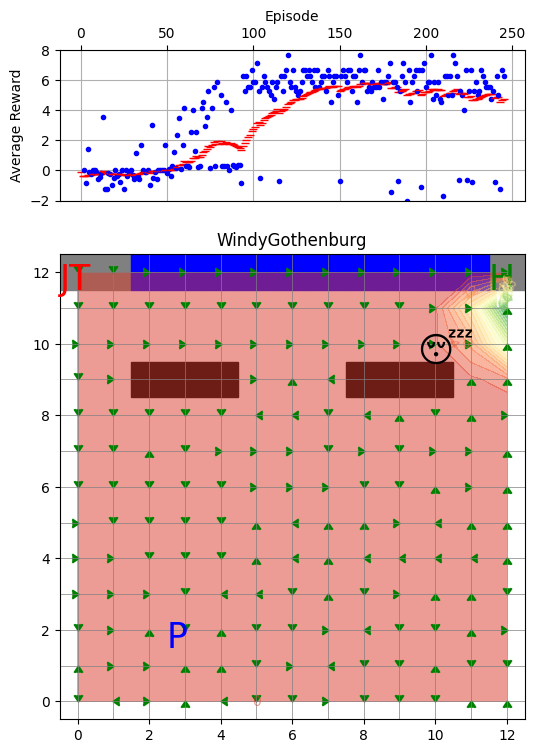

In [32]:
# Space for your own experiments and tests
"""
!!! PLEASE COMMENT OUT ALL CALLS TO eval_hyperparam_grid BEFORE SUBMISSION !!!
"""
# Create environment with YOUR chosen pripps_reward, not the default one

env_config = PRIPPS_ENV.copy()
env_config['pripps_reward'] = pripps_reward  # Use your chosen value (3)

env = WindyGothenburg(**env_config)
control_policy, stats = learn_q(env, epsilon=pripps_epsilon, gamma=pripps_gamma, 
                               A=pripps_A, B=pripps_B, num_episodes=250, 
                               render=True)

stats = eval_learning_params(WindyGothenburg, PRIPPS_ENV, learn_q, 
                             epsilon=pripps_epsilon, gamma=pripps_gamma, 
                             A=pripps_A, B=pripps_B, pripps_reward=pripps_reward,
                             max_steps_for_success=20)

# paramgrid = HyperParameterGrid(epsilon=[0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 0.99], 
#                          gamma=[0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 0.99], 
#                          A=[150], B=[300])

# stats = eval_hyperparam_grid(PRIPPS_ENV, paramgrid, max_steps_for_success=20, 
#                              save_name='hpg_basic_eps_gamma')

print(stats)

In [ ]:
PRIPPS_ENV = {'name': 'Pripps Env',
             'w': 12, 'h': 12,                            # width and height of the grid
             'obstacles': {(2,9), (3,9), (4,9),
                          (8,9), (9,9), (10,9)},          # Coordinates of obstacles on the grid 
             'water': {(k, 12) for k in range(2, 12)},    # Coordinates of the Göta Älv 
             'pripps_reward': 1.828}                      # Reward for passing by J.A. Pripps 

stats = eval_learning_params(WindyGothenburg, PRIPPS_ENV, learn_q, 
                             epsilon=pripps_epsilon, gamma=pripps_gamma, 
                             A=pripps_A, B=pripps_B, pripps_reward=pripps_reward,
                             max_steps_for_success=20)
assert stats['avg_success_rate'] > 0.9, 'Got {} instead'.format(stats['avg_success_rate'])
print("The achieved average success rate was ", stats['avg_success_rate'])

* Reflect on this part of the assignment and write down your insights in a few brief sentences. ***[1p]***
* Make sure to touch upon:
  * the final value of `pripps_reward` that you chose and why you have chosen that value;
  * the impact of `pripps_reward` and $\gamma$ on solving the problem

YOUR ANSWER HERE

gamma 0.3 reward 0.2 {'avg_success_rate': 0.916, 'avg_eps_goal_found': 25.28, 'avg_eps_goal_learned': 98.604, 'avg_max_r_smoothed': 5.834616186499056, 'epsilon': 0.01, 'gamma': 0.3, 'A': 150, 'B': 300, 'pripps_reward': 0.2}

gamma 0.6 reward 0.2 {'avg_success_rate': 0.54, 'avg_eps_goal_found': 32.588, 'avg_eps_goal_learned': 155.476, 'avg_max_r_smoothed': 3.726297057672848, 'epsilon': 0.01, 'gamma': 0.6, 'A': 150, 'B': 300, 'pripps_reward': 0.2}


---

That is all there is. If you are done,

* Save the notebook
* Upload the .ipynb file to Canvas
* Tell your teammate how much you appreciated their invaluable insights and how fun it was to collaborate with them on the assignments.